# Figure 8: Effect of Diffusion Constants on Turing Pattern Formation

## Introduction
In this notebook, we analyse the effect of diffusion constants $D_X$, $D_Y$ on Turing pattern formation, particularly on Turing instability (all types) and Turing type 1.

The notebook serves as a tutorial for the *figure8_HS_v3.py* script.

The script generates all 4 figures simultaneously, whereas here we will demonstrate by plotting them one by one.
***
***

## Code

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.signal import argrelextrema
import time
from multiprocessing.pool import ThreadPool #replaced with import multiprocessing for .py script
import matplotlib
import matplotlib.pyplot as plt

### 2. Define Functions

First, we define the random matrix generating function *gen_matrix_F()* with parameters *n* (network size) and *vr* (variance).

In [3]:
def gen_matrix_F(n,vr):
    I = np.eye(n)
    mu = 0
    B = mu + np.sqrt(vr) * np.random.randn(n, n)
    np.fill_diagonal(B, 0)
    A = -I + B
    D = np.zeros((n, n))
    return A, D

Next, we define *process_tuple()* function which computes the Turing and Turing I percentage for each case (tuplet): $(D_{x_1}, D_{y_1}), (D_{x_2}, D_{y_2}), ..., (D_{x_n}, D_{y_n})$.

The function returns percentage of observed Turing I instability for a given diffusion constant pair.

Note:
- In this example, 1,000 matrices are generated for each $(D_x, D_y)$ pair. This number can be changed in the first for loop of the function.
- In order to compute and visualise all 4 cases (N =2,3,5,50) simultaneously, we pass ((*N*,$σ^2$), $D_{x}$, $D_{y}$) to the function. <br>
$(N,σ^2)$ part is assigned to a variable *p* which is fed to *gen_matrix_F()* function.


In [4]:
def process_tuple(tuplet):
    p, Dx, Dy = tuplet
    D = gen_matrix_F(p[0], p[1])[1]
    D[0, 0] = Dx
    D[1, 1] = Dy
    k = np.arange(0, 10, 0.2)

    count_t1a = 0
    count_t1b = 0
    count_t2a = 0
    count_t2b = 0

    for _ in range(1000):  # 1,000 matrices
        m = gen_matrix_F(p[0], p[1])[0]
        ev = np.linalg.eigvals(m)
        if np.max(np.real(ev)) < 0:  # if matrix is stable
            Em = []
            Emi = []
            for ki in k:
                R = m - D * (ki ** 2)
                eigval = np.linalg.eigvals(R)
                Em.append(np.max(np.real(eigval)))
                idx_max = np.argmax(np.real(eigval))
                Emi.append(np.imag(eigval[idx_max]))
            a = np.max(Em)
            index = np.argmax(Em)
            nEm = np.array(Em)
            if a > 0:
                if Emi[index] == 0:
                    numZeroCrossing = np.count_nonzero(np.diff(np.sign(Em)))  # Count zero crossings
                    numpositivelocalmaxima = np.sum(nEm[argrelextrema(nEm, np.greater)] > 0) > 0
                    if numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 0:
                        count_t1a += 1
                    elif numpositivelocalmaxima > 0 and numZeroCrossing == 1:
                        count_t1b += 1
                    elif numpositivelocalmaxima == 0 and numZeroCrossing % 2 == 1:
                        count_t2a += 1
                    elif numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 1:
                        count_t2b += 1

    percent_turing_1 = (count_t1a + count_t1b) * 0.1
    percent_turing = (count_t1a + count_t1b + count_t2a + count_t2b) * 0.1
    return percent_turing_1, percent_turing

### 3. Set Parameters
This is where the diffusion constants and network size-variance pairs are intialised.


In this notebook, a coarser grid of 10 steps in the logarithmic space. A finer grid of 100 steps is used in the *figure8_re_v3.py* script.

The diffusion constants can be adjusted here as needed for more accuracy.

In [32]:
# diffusion constants
dx = np.logspace(-3, 3, 10)
dy = np.logspace(-3, 3, 10)

The *params* variable represents cases we want to visualise (N, var).

In this notebook, we define and plot each case separately.

In the actual python script, the parameters are defined as *parameters = [(2, 1/2), (3, 1/3), (5, 1/5), (50, 1/50)]*

The variance is picked in line with $σ^2$ = $\frac{1}{N}$ (refer to Figure 7).
- *N* = 2,  $σ^2$ = 1/2
- *N* = 3,  $σ^2$ = 1/3
- *N* = 5,  $σ^2$ = 1/5
- *N* = 50,  $σ^2$ = 1/50

For demonstration purposes, let us use $N=5$.

In [33]:
# network size n and matrix variance vr
parameters = [(5, 1/5)]  # (N, var)

### 4. Generate and Visualise Data

In this cell, we compute our data by calling the *process_tuple()* function defined above and by using multithreading. <br><br>

<span style="color:red">Note 1</span>: A finer grid is used in the figure8_HS_v3.py file

<span style="color:red">Note 2</span>: ThreadPool python is not actually running multiple processes in parallel but instead is running multiple threads in parallel. ThreadPool is used here because it is compatible with the Jupyter Notebooks. In the *figure8_HS_v3.py* script, we use *multiprocessing* package.

### *N = 5*

In [34]:
dp_list = [(par, x, y) for par in parameters for x in dx for y in dy]
start_time = time.time()
# Number of cores to use
num_cores = 2

# creating multiprocessing pool
pool = ThreadPool(processes=num_cores)

# using the pool to apply the process_tuple function to each tuple in the list
results = pool.map(process_tuple, dp_list)
# Close the pool
pool.close()
pool.join()

end_time = time.time()

percent_turing_1 = [res[0] for res in results]
percent_turing = [res[1] for res in results]

df_data = pd.DataFrame({'N': [x[0][0] for x in dp_list], 'Dx': [x[1] for x in dp_list], 'Dy': [x[2] for x in dp_list], 'Percentage_Turing_1': percent_turing_1,
        'Percentage_Turing': percent_turing})
df_data.to_csv(os.path.join('./', 'heatmap_fig8.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 474.28 seconds


After running the above cell, we obtain the following dataframe with 5 columns (N, $D_x$, $D_y$, Turing I percentage, Turing percentage):

This dataframe is saved as a csv file.

In [35]:
path = './heatmap_fig8.csv'
data = pd.read_csv(path)
data.head()

,N,Dx,Dy,Percentage_Turing_1,Percentage_Turing
0,5,0.001,0.001000,0.0,0.0
1,5,0.001,0.004642,0.0,0.1
2,5,0.001,0.021544,0.0,0.1
3,5,0.001,0.100000,0.3,0.4
4,5,0.001,0.464159,0.5,0.7


Creating new dataframes based on unique *N* values.

In [36]:
# Compute log10 of Dx and Dy
data['log_Dx'] = np.log10(data['Dx'])
data['log_Dy'] = np.log10(data['Dy'])

# N = 5
df_n = data[data['N'] == 5]
per = np.array(df_n['Percentage_Turing'])
log_dx = np.array(df_n['log_Dx'])
log_dy = np.array(df_n['log_Dy'])
            
l = len(np.unique(log_dx))
percentage = [per[i:i + l] for i in range(0, len(per), l)]

Plotting the heat map

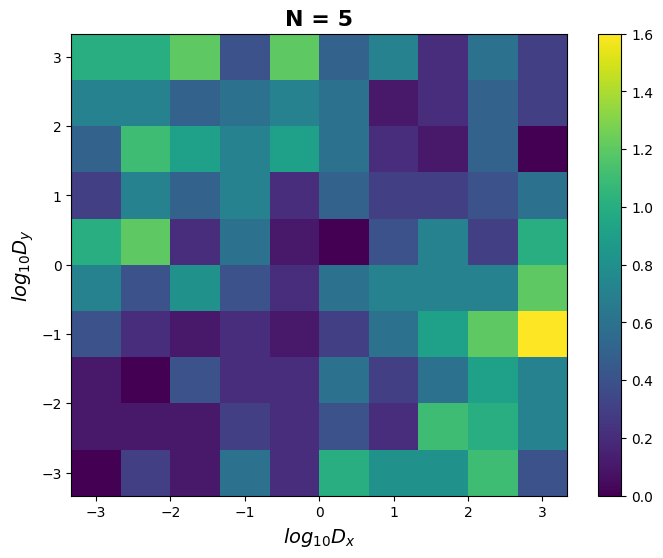

In [37]:
Y, X = np.meshgrid(np.unique(log_dy), np.unique(log_dx))
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 5', fontsize = 16,  fontweight = 'bold')
plt.show()

Alternatively, percentage Turing 1 can also be plotted by specifying the variable `per`.

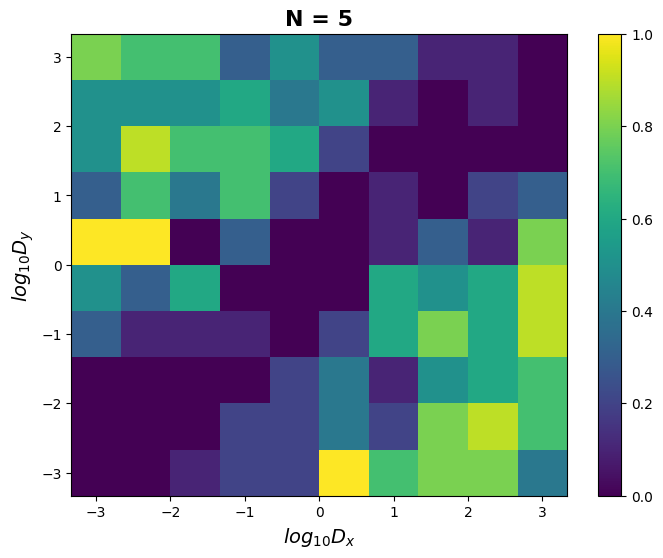

In [38]:
per = np.array(df_n['Percentage_Turing_1'])
percentage = [per[i:i+l] for i in range(0, len(per), l)]

Y, X = np.meshgrid(np.unique(log_dy), np.unique(log_dx))
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 5', fontsize = 16,  fontweight = 'bold')
plt.show()